# OFA: Image Captioning with Transformers
In this notebook, we will show how to run the inference of OFA on image captioning with our support of OFA on Huggingface Transformers. 

In brief, the whole process is simple. After building the environment and cloning the related codes and checkpoints, what you need to do is just to provide an image with some simple preprocessing, build the model and generator (either Fairseq generator that we provide or HF native generator), and obtain the result.


In [1]:
!git clone --single-branch --branch feature/add_transformers https://github.com/OFA-Sys/OFA.git

fatal: destination path 'OFA' already exists and is not an empty directory.


In [2]:
!pip install OFA/transformers/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./OFA/transformers
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for transformers: filename=transformers-4.18.0.dev0-py3-none-any.whl size=3916779 sha256=fa3adebfc737e5732c4e2c3fe704c75a0a4cc580f1598d7d7efa07f0767a60b9
  Stored in directory: /tmp/pip-ephem-wheel-cache-iouu9_n6/wheels/20/01/92/4b280d748de8d14733cd3027f54a4fae2fcd95479148c48cf3
Successfully built transformers
  Attempting uninstal

In [3]:
!git lfs install
#!git clone https://huggingface.co/OFA-Sys/OFA-tiny
!git clone https://huggingface.co/OFA-Sys/OFA-huge

Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.
Cloning into 'OFA-huge'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 40 (delta 19), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (40/40), done.
tcmalloc: large alloc 1471086592 bytes == 0x55f5e8c78000 @  0x7fbc52c582a4 0x55f5acb9578f 0x55f5acb728db 0x55f5acb275b3 0x55f5acacb34a 0x55f5acacb806 0x55f5acae8ad1 0x55f5acae9069 0x55f5acae9593 0x55f5acb8e482 0x55f5aca2ecc2 0x55f5aca15a75 0x55f5aca16735 0x55f5aca1573a 0x7fbc51f9fc87 0x55f5aca1578a
tcmalloc: large alloc 2206621696 bytes == 0x55f640768000 @  0x7fbc52c582a4 0x55f5acb9578f 0x55f5acb728db 0x55f5acb275b3 0x55f5acacb34a 0x55f5acacb806 0x55f5acae8ad1 0x55f5acae9069 0x55f5acae9593 0x55f5acb8e482 0x55f5aca2ecc2 0x55f5aca15a75 0x55f5aca16735 0x55f5aca1573a 0x7fbc51f9

In [4]:
from PIL import Image
from torchvision import transforms
from transformers import OFATokenizer, OFAModel
from transformers.models.ofa.generate import sequence_generator

In [5]:
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
resolution = 256

In [6]:
patch_resize_transform = transforms.Compose([
    lambda image: image.convert("RGB"),
    transforms.Resize((resolution, resolution), interpolation=Image.BICUBIC),
    transforms.ToTensor(), 
    transforms.Normalize(mean=mean, std=std)
])

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [7]:
!ls
ckpt_dir='./OFA-huge'
tokenizer = OFATokenizer.from_pretrained(ckpt_dir)

OFA  OFA-huge  OFA-tiny  sample_data  test.jpg
./OFA-huge
<super: <class 'OFATokenizer'>, <OFATokenizer object>>


In [16]:
txt = " what does the image describe, in detail?"
inputs = tokenizer([txt], return_tensors="pt").input_ids
!wget http://farm4.staticflickr.com/3539/3836680545_2ccb331621_z.jpg 
!mv 3836680545_2ccb331621_z.jpg  test.jpg
!ls
img = Image.open('./test.jpg')
patch_img = patch_resize_transform(img).unsqueeze(0)

--2022-12-29 14:35:03--  http://farm4.staticflickr.com/3539/3836680545_2ccb331621_z.jpg
Resolving farm4.staticflickr.com (farm4.staticflickr.com)... 18.65.237.84, 2600:9000:234d:ea00:0:5a51:64c9:c681, 2600:9000:234d:7e00:0:5a51:64c9:c681, ...
Connecting to farm4.staticflickr.com (farm4.staticflickr.com)|18.65.237.84|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://farm4.staticflickr.com/3539/3836680545_2ccb331621_z.jpg [following]
--2022-12-29 14:35:03--  https://farm4.staticflickr.com/3539/3836680545_2ccb331621_z.jpg
Connecting to farm4.staticflickr.com (farm4.staticflickr.com)|18.65.237.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘3836680545_2ccb331621_z.jpg’

3836680545_2ccb3316     [ <=>                ] 131.20K  --.-KB/s    in 0.02s   

2022-12-29 14:35:03 (8.37 MB/s) - ‘3836680545_2ccb331621_z.jpg’ saved [134347]

OFA  OFA-huge  OFA-tiny  sample_data  test.jpg


In [17]:
model = OFAModel.from_pretrained(ckpt_dir, use_cache=False)

## Choice of Generators
We find that using our provided generator can consistently achieve a better performance on the benchmark evaluation. Therefore, we first provide a demonstration of how to use this generator, and later the native one from Transformers. 

In [18]:
generator = sequence_generator.SequenceGenerator(
    tokenizer=tokenizer,
    beam_size=5,
    max_len_b=16,
    min_len=0,
    no_repeat_ngram_size=3,
)

In [19]:
import torch
data = {}
data["net_input"] = {"input_ids": inputs, 'patch_images': patch_img, 'patch_masks':torch.tensor([True])}

In [20]:
gen_output = generator.generate([model], data)
gen = [gen_output[i][0]["tokens"] for i in range(len(gen_output))]

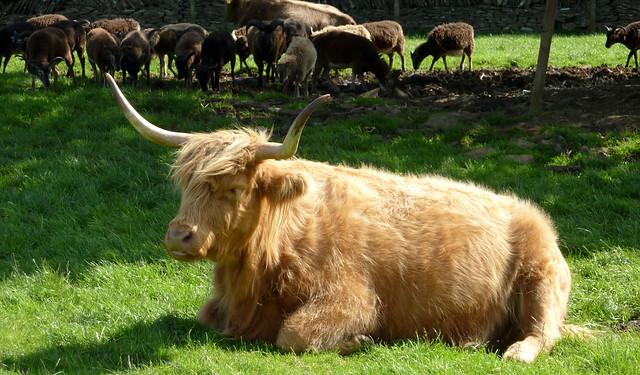

yes, there is a cow with horns.


In [21]:
display(img)
print(tokenizer.batch_decode(gen, skip_special_tokens=True)[0].strip())

In [30]:
gen = model.generate(inputs, patch_images=patch_img, num_beams=10, no_repeat_ngram_size=3)

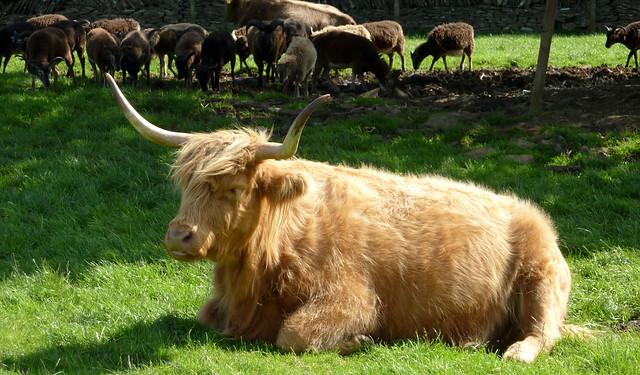

yes, there is a cow with horns.


In [31]:
display(img)
print(tokenizer.batch_decode(gen, skip_special_tokens=True)[0].strip())